# L6: Chat Agent with Function Calling

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
import pprint
import gradio as gr
from typing import List
from haystack import component, Pipeline, Document
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from haystack.components.joiners import BranchJoiner
from haystack_experimental.components.tools import OpenAIFunctionCaller

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

### Create RAG Pipeline as a Function

In [3]:
template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""
rag_pipe = Pipeline()
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipe.add_component("llm", OpenAIGenerator())

rag_pipe.connect("prompt_builder", "llm")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

In [4]:
def rag_pipeline_func(query: str):
    documents = [
        Document(content="My name is Jean and I live in Paris."),
        Document(content="My name is Mark and I live in Berlin."),
        Document(content="My name is Giorgio and I live in Rome."),
        Document(content="My name is Marta and I live in Madrid."),
        Document(content="My name is Harry and I live in London."),
    ]
    result = rag_pipe.run({"prompt_builder": {"question": query, 
                                              "documents": documents}})
    return {"reply": result["llm"]["replies"][0]}

### Create a Weather Function

In [5]:
WEATHER_INFO = {
    "Berlin": {"weather": "mostly sunny", "temperature": 7, "unit": "celsius"},
    "Paris": {"weather": "mostly cloudy", "temperature": 8, "unit": "celsius"},
    "Rome": {"weather": "sunny", "temperature": 14, "unit": "celsius"},
    "Madrid": {"weather": "sunny", "temperature": 10, "unit": "celsius"},
    "London": {"weather": "cloudy", "temperature": 9, "unit": "celsius"},
}

def get_current_weather(location: str):
    if location in WEATHER_INFO:
        return WEATHER_INFO[location]
    else:
        return {"weather": "sunny", "temperature": 70, "unit": "fahrenheit"}

### Define Tools

In [6]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "rag_pipeline_func",
            "description": "Get information about where people live",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                    }
                },
                "required": ["query"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {"type": "string", "description": "The city"}
                },
                "required": ["location"],
            },
        },
    },
]

### Create an OpenAIChatGenerator
The [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator?utm_campaign=developer-relations&utm_source=dlai) allows chat completions using OpenAI LLMs. 

Messages can come from the following roles:
- system
- assistant
- user
- function

In [7]:
chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
replies = chat_generator.run(messages=[ChatMessage.from_user("Where does Mark live?")])

In [8]:
print(replies['replies'][0])

ChatMessage(content='[{"id": "call_ZBBcwE3CEuTUPqjGaAHFajpV", "function": {"arguments": "{\\"query\\":\\"Where does Mark live?\\"}", "name": "rag_pipeline_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 20, 'prompt_tokens': 104, 'total_tokens': 124, 'completion_tokens_details': {'reasoning_tokens': 0}}})


### Calling the function
> Here, we are using a component from the `haystack_experimental` package: the [`OpenAIFunctionCaller`](https://github.com/deepset-ai/haystack-experimental/blob/main/haystack_experimental/components/tools/openai/function_caller.py)

In [9]:
function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline_func, 
                                                            "get_current_weather": get_current_weather})

results = function_caller.run(messages=replies['replies'])

In [10]:
pprint.pprint(results["function_replies"])

[ChatMessage(content='[{"id": "call_ZBBcwE3CEuTUPqjGaAHFajpV", "function": '
                     '{"arguments": "{\\"query\\":\\"Where does Mark '
                     'live?\\"}", "name": "rag_pipeline_func"}, "type": '
                     '"function"}]',
             role=<ChatRole.ASSISTANT: 'assistant'>,
             name=None,
             meta={'finish_reason': 'tool_calls',
                   'index': 0,
                   'model': 'gpt-3.5-turbo-0125',
                   'usage': {'completion_tokens': 20,
                             'completion_tokens_details': {'reasoning_tokens': 0},
                             'prompt_tokens': 104,
                             'total_tokens': 124}}),
 ChatMessage(content='{"reply": "Mark lives in Berlin."}',
             role=<ChatRole.FUNCTION: 'function'>,
             name='rag_pipeline_func',
             meta={})]


### Create a Chat Agent with Tools


In [11]:
message_collector = BranchJoiner(List[ChatMessage])
chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline_func, 
                                                            "get_current_weather": get_current_weather})

chat_agent = Pipeline()
chat_agent.add_component("message_collector", message_collector)
chat_agent.add_component("generator", chat_generator)
chat_agent.add_component("function_caller", function_caller)

chat_agent.connect("message_collector", "generator.messages")
chat_agent.connect("generator", "function_caller")
chat_agent.connect("function_caller.function_replies", "message_collector")


🚅 Components
  - message_collector: BranchJoiner
  - generator: OpenAIChatGenerator
  - function_caller: OpenAIFunctionCaller
🛤️ Connections
  - message_collector.value -> generator.messages (List[ChatMessage])
  - generator.replies -> function_caller.messages (List[ChatMessage])
  - function_caller.function_replies -> message_collector.value (List[ChatMessage])

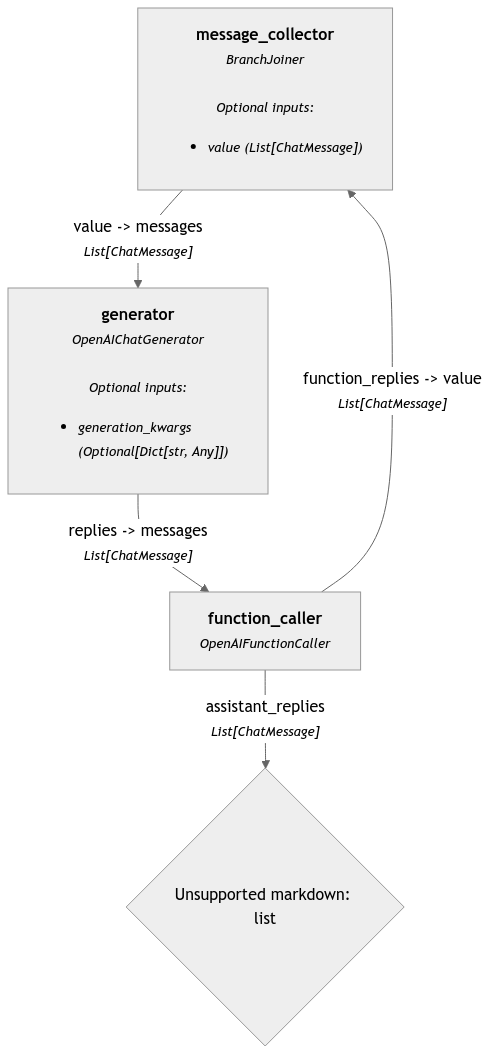

In [12]:
chat_agent.show()

In [ ]:
messages = [
    ChatMessage.from_system(
        """If needed, break down the user's question into simpler questions and follow-up questions that you can use with your tools.
        Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
    )
]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    print(response['function_caller']['assistant_replies'][0].content)

### Gradio Chat App

Find out more information about **Gradio** [here](https://huggingface.co/gradio).

In [ ]:
messages = [
        ChatMessage.from_system(
            """If needed, break down the user's question to simpler questions and follow-up questions that you can use with your tools.
            Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
        )
    ]
def chat(message, history): 
    messages.append(ChatMessage.from_user(message))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    return response['function_caller']['assistant_replies'][0].content

In [ ]:
demo = gr.ChatInterface(
    fn=chat,
    examples=[
        "Can you tell me where Giorgio lives?",
        "What's the weather like in Madrid?",
        "Who lives in London?",
        "What's the weather like where Mark lives?",
    ],
    title="Ask me about weather or where people live!",
)
demo.launch(share=True)